# Supervised learning demo (Vanilla GP vs F-PACOH)

In this demonstration notebook, we
1. Set up a simple 1d meta-learning environment, generate meta-training data and a test task for inspecting the different models' predictions
2. Fit a vanilla GP with an SE kernel on 5 training points from the test task as a reference / baseline
3. Meta-train F-PACOH on the meta-training data and fit the meta-learned GP to the same 5 training points of the test task. This allows us to compare the Vanilla GP with the F-PACOH GP predictions 1-to-1.

## 1. Setting up the meta-learning environment

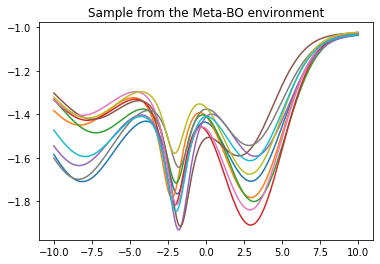

In [7]:
from matplotlib import pyplot as plt
from meta_bo.meta_environment import RandomMixtureMetaEnv
import numpy as np

# setup meta-learning / meta-bo environment
rds = np.random.RandomState(26)
meta_env = RandomMixtureMetaEnv(random_state=rds)

# sample functions / BO tasks from the meta-env
envs = meta_env.sample_envs(num_envs=10)
meta_train_data = meta_env.generate_uniform_meta_train_data(num_tasks=20, num_points_per_task=20)
meta_test_data =  meta_env.generate_uniform_meta_valid_data(num_tasks=50, num_points_context=10, num_points_test=50)

# setup test task
test_env = meta_env.sample_env()
x_context, y_context = test_env.generate_uniform_data(num_points=5)

# visualize samples from the meta-bo env
x_plot = np.linspace(meta_env.domain.l, meta_env.domain.u, 200)
for env in envs:
    plt.plot(x_plot, env.f(x_plot))
plt.title('Sample from the Meta-BO environment')
plt.show()

## 2. Fit Vanilla GP

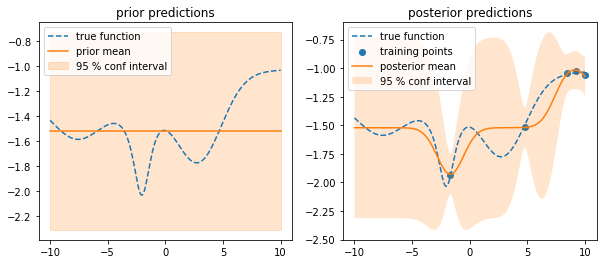

In [8]:
from meta_bo.models.vanilla_gp import GPRegressionVanilla
vanilla_gp = GPRegressionVanilla(input_dim=test_env.domain.d, kernel_lengthscale=0.2,
                             normalization_stats=meta_env.normalization_stats, random_state=rds)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
x_plot = np.linspace(test_env.domain.l, test_env.domain.u, num=200)

# get prior predictions
prior_mean, prior_std = vanilla_gp.predict(x_plot)
prior_ucb, prior_lcb = vanilla_gp.confidence_intervals(x_plot, confidence=0.95)

# fit vanilla GP on test task
vanilla_gp.add_data(x_context, y_context)
pred_mean, pred_std = vanilla_gp.predict(x_plot)
ucb, lcb = vanilla_gp.confidence_intervals(x_plot, confidence=0.95)

# visualizing the results
axes[0].plot(x_plot, test_env.f(x_plot), linestyle='--', label='true function')
axes[0].plot(x_plot, prior_mean, label='prior mean')
axes[0].fill_between(x_plot.flatten(), prior_ucb, prior_lcb, alpha=0.2, label='95 % conf interval',
                     color='#ff7f0e')
axes[0].set_title('prior predictions')
axes[0].legend()

axes[1].plot(x_plot, test_env.f(x_plot), linestyle='--', label='true function')
axes[1].scatter(x_context, y_context, label='training points')
axes[1].plot(x_plot, pred_mean, label='posterior mean')
axes[1].fill_between(x_plot.flatten(), ucb, lcb, alpha=0.2, label='95 % conf interval')
axes[1].set_title('posterior predictions')
axes[1].legend()
plt.show()

3. ## Meta-train + Fit F-PACOH

Iter 1/6000 - Loss: 2.032120 - Time 0.02 sec - Valid-LL: 0.149 - Valid-RMSE: 0.226 - Calib-Err 0.127


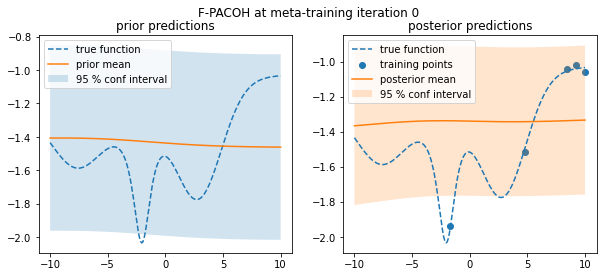

Iter 2/6000 - Loss: 1.965498 - Time 0.01 sec - Valid-LL: 0.195 - Valid-RMSE: 0.218 - Calib-Err 0.124
Iter 501/6000 - Loss: 0.898037 - Time 6.99 sec - Valid-LL: 0.687 - Valid-RMSE: 0.124 - Calib-Err 0.130
Iter 1001/6000 - Loss: 0.937788 - Time 7.04 sec - Valid-LL: 0.859 - Valid-RMSE: 0.116 - Calib-Err 0.124
Iter 1501/6000 - Loss: 0.943772 - Time 7.09 sec - Valid-LL: 1.019 - Valid-RMSE: 0.112 - Calib-Err 0.117
Iter 2001/6000 - Loss: 1.045706 - Time 7.01 sec - Valid-LL: 1.203 - Valid-RMSE: 0.095 - Calib-Err 0.117


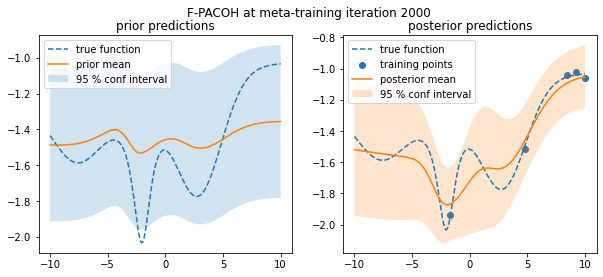

Iter 2002/6000 - Loss: 1.104093 - Time 0.01 sec - Valid-LL: 1.204 - Valid-RMSE: 0.095 - Calib-Err 0.117
Iter 2501/6000 - Loss: 1.074422 - Time 7.00 sec - Valid-LL: 1.413 - Valid-RMSE: 0.079 - Calib-Err 0.121
Iter 3001/6000 - Loss: 1.070914 - Time 6.97 sec - Valid-LL: 1.572 - Valid-RMSE: 0.073 - Calib-Err 0.116
Iter 3501/6000 - Loss: 1.068540 - Time 6.99 sec - Valid-LL: 1.688 - Valid-RMSE: 0.070 - Calib-Err 0.111
Iter 4001/6000 - Loss: 1.064950 - Time 7.18 sec - Valid-LL: 1.778 - Valid-RMSE: 0.067 - Calib-Err 0.106


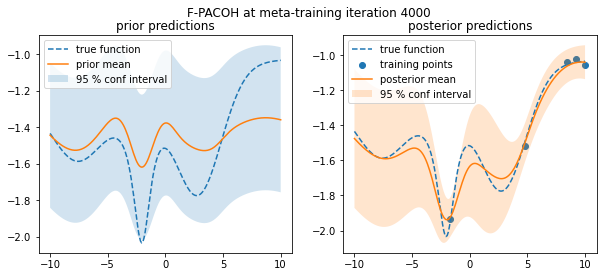

Iter 4002/6000 - Loss: 1.044044 - Time 0.01 sec - Valid-LL: 1.778 - Valid-RMSE: 0.068 - Calib-Err 0.106
Iter 4501/6000 - Loss: 1.062211 - Time 7.20 sec - Valid-LL: 1.809 - Valid-RMSE: 0.068 - Calib-Err 0.103
Iter 5001/6000 - Loss: 1.061424 - Time 7.26 sec - Valid-LL: 1.844 - Valid-RMSE: 0.066 - Calib-Err 0.101
Iter 5501/6000 - Loss: 1.062785 - Time 7.31 sec - Valid-LL: 1.851 - Valid-RMSE: 0.067 - Calib-Err 0.100
Iter 6001/6000 - Loss: 1.062174 - Time 7.29 sec - Valid-LL: 1.856 - Valid-RMSE: 0.067 - Calib-Err 0.099


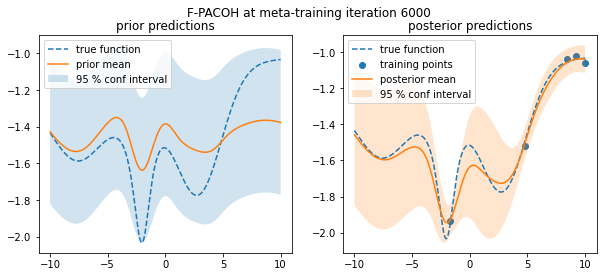

In [9]:
from meta_bo.models.f_pacoh_map import FPACOH_MAP_GP
import warnings

warnings.filterwarnings("ignore") # filter some numerical warnings to make the logs cleaner
NN_LAYERS = (32, 32)
fpacoh_model = FPACOH_MAP_GP(domain=meta_env.domain, num_iter_fit=6000, weight_decay=1e-4, prior_factor=0.1,
                             task_batch_size=5, covar_module='NN', mean_module='NN',
                             mean_nn_layers=NN_LAYERS, kernel_nn_layers=NN_LAYERS, random_state=rds)

# meta-train and plot the predictions every 2000 iterations
for i in range(4):
    # meta-training for 2000 iterations
    fpacoh_model.meta_fit(meta_train_data, meta_valid_tuples=meta_test_data, log_period=500,
                          n_iter=2000 if i > 0 else 1)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
    x_plot = np.linspace(test_env.domain.l, test_env.domain.u, num=200)

    # get prior predictions
    fpacoh_model.reset_to_prior()
    prior_mean, prior_std = fpacoh_model.predict(x_plot)
    prior_ucb, prior_lcb = fpacoh_model.confidence_intervals(x_plot, confidence=0.95)


    # fitting the meta-learned GP on the test task
    fpacoh_model.add_data(x_context, y_context)
    x_plot = np.linspace(test_env.domain.l, test_env.domain.u, num=200)
    pred_mean, pred_std = fpacoh_model.predict(x_plot)
    ucb, lcb = fpacoh_model.confidence_intervals(x_plot, confidence=0.95)

    # visualizing the results
    axes[0].plot(x_plot, test_env.f(x_plot), linestyle='--', label='true function')
    axes[0].plot(x_plot, prior_mean, label='prior mean')
    axes[0].fill_between(x_plot.flatten(), prior_ucb, prior_lcb, alpha=0.2, label='95 % conf interval')
    axes[0].set_title('prior predictions')
    axes[0].legend()

    axes[1].plot(x_plot, test_env.f(x_plot), linestyle='--', label='true function')
    axes[1].scatter(x_context, y_context, label='training points')
    axes[1].plot(x_plot, pred_mean, label='posterior mean')
    axes[1].fill_between(x_plot.flatten(), ucb, lcb, alpha=0.2, label='95 % conf interval')
    axes[1].set_title('posterior predictions')
    axes[1].legend()
    plt.suptitle(f'F-PACOH at meta-training iteration {i*2000}')
    plt.show()

    fpacoh_model._reset_data()